# Архитектуры CNN

Мы рассмотрели базовые компоненты, из которых состоят современные сверточные нейронные сети, а также техники их обучения.

<img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img/L09_CNN_Architectures_1.png"  width="700">

<img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img/l09.png" >

<img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img/l09_2.png" width="760">

На этом занятии рассмортим, какие именно модели можно построить на основе этих компонент. 

#ImageNet


<img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img/L09_CNN_Architectures_2.png"  width="700">

[Условия соревнования](http://image-net.org/challenges/LSVRC/2017/)

Загрузка с [официального сайта](http://image-net.org/download) недоступна, но можно загрузить данные с [Kaggle](https://www.kaggle.com/c/imagenet-object-localization-challenge/data)

Однако архив занимает порядка 156Gb и не поместится на диск Colab. Поэтому воспользуемся другим репозиторием, в котором находится 1000 изображений из оригинального датасета.

P.S. Для загрузки данных, которые стали недоступны на официальных сайтах, [можно использовать](https://academictorrents.com). В частности для [ImageNet](https://academictorrents.com/browse.php?search=imagenet)

In [11]:
#Фиксируем random_seed
import torch
import random
import numpy as np
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

#Выставлям device для расчетов
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [1]:
# Full list of labels 
!wget 'https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json'
!git clone https://github.com/ajschumacher/imagen.git

--2021-07-08 11:44:20--  https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.92.110
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.92.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35363 (35K) [application/octet-stream]
Saving to: ‘imagenet_class_index.json’

imagenet_class_inde 100%[===================>]  34.53K  --.-KB/s    in 0.002s  

2021-07-08 11:44:21 (20.7 MB/s) - ‘imagenet_class_index.json’ saved [35363/35363]

Cloning into 'imagen'...
remote: Enumerating objects: 1004, done.
remote: Total 1004 (delta 0), reused 0 (delta 0), pack-reused 1004
Receiving objects: 100% (1004/1004), 99.90 MiB | 42.73 MiB/s, done.
Resolving deltas: 100% (1/1), done.


Загрузили категории

In [7]:
from PIL import Image
import json
import pprint
pp = pprint.PrettyPrinter(width=41, compact=True)

with open('imagenet_class_index.json') as f:
      imagenet_labels = json.load(f)

pp.pprint(dict(list(imagenet_labels.items())[:10])) # Используем Pretty Print для отображения длинных dict

armadillo = Image.open('imagen/imagen/n02454379_10511_armadillo.jpg')
sunglasses = Image.open('imagen/imagen/n04356056_8960_sunglasses.jpg')
volleyball = Image.open('imagen/imagen/n04540053_14903_volleyball.jpg')
microwave = Image.open('imagen/imagen/n03761084_32799_microwave.jpg')
strawberry = Image.open('imagen/imagen/n07745940_1671_strawberry.jpg')
goldfish = Image.open('imagen/imagen/n01443537_2625_goldfish.jpg')


{'0': ['n01440764', 'tench'],
 '1': ['n01443537', 'goldfish'],
 '2': ['n01484850', 'great_white_shark'],
 '3': ['n01491361', 'tiger_shark'],
 '4': ['n01494475', 'hammerhead'],
 '5': ['n01496331', 'electric_ray'],
 '6': ['n01498041', 'stingray'],
 '7': ['n01514668', 'cock'],
 '8': ['n01514859', 'hen'],
 '9': ['n01518878', 'ostrich']}


In [8]:
import json
from glob import glob
from PIL import Image
from torch.utils.data import Dataset

class MicroImageNet(Dataset):
  def __init__(self):
    super().__init__()
    # Load labels
    self.num2id = {}
    with open('imagenet_class_index.json') as f:
      imagenet_labels = json.load(f)
    w_net = {}
    # Because not world net all image codes from imagen exists in imagenet_labels 
    # we need to filter this image
    for key in imagenet_labels.keys():
      wn_id = imagenet_labels[key][0]
      w_net[wn_id] = {'num': int(key), 'name': imagenet_labels[key][1] }
    self.labels = []
    self.paths = []

    # Load data
    images = glob('imagen/imagen/*.jpg')
    images.sort()
    for i, path in enumerate(images):
      name = path.split("_")[2] # Class name
      id = path.split("_")[0][14:] # WorldNet based ID
      if w_net.get(id,None): 
        self.labels.append([w_net[id]['num'], w_net[id]['name'], id])
        self.paths.append(path)
    
  def __getitem__(self,idx):
    im = Image.open(self.paths[idx])
    class_num = self.labels[idx][0]
    return im, class_num

  def __len__(self):
    return len(self.paths)


microImgNet = MicroImageNet()


Посмотрим на картинки

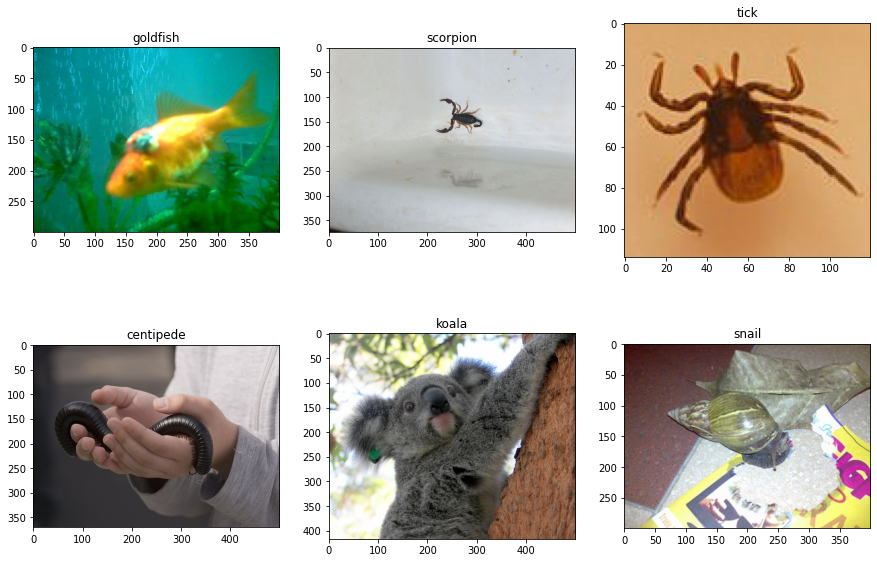

In [9]:
from PIL import Image
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,10)
plt.tight_layout()

def show(img,label1,num,label2=""):
    ax = plt.subplot(2, 3,num+1)
    plt.imshow(img)
    plt.title(label1)
    ax.set_xlabel(label2)
  

for i in range(6):
  im, cls = microImgNet[i*6]
  name = microImgNet.labels[i*6][1]
  show(im,name,i)

## 2012 AlexNet


создатели: Alex Krizhevsky, Ilya Sutskever, Geoffrey E. Hinton
**University of Toronto**

Как упомяналось на первой лекции, современный бум нейростевых технологий начался в 2012 году, когда AlexNet с большим отрывом от конкурентов победила в ImageNet.

<img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img/L09_CNN_Architectures_3.png"  width="1000">


Особенности:
- Большие фильтры на первых слоях
- Обучалась на двух видеокартах  GTX580 ( ... )
- Уменьшение размерности
- 2 Полносвязанных слоя в конце

[Подробнее про AlexNet](https://neurohive.io/ru/vidy-nejrosetej/alexnet-svjortochnaja-nejronnaja-set-dlja-raspoznavanija-izobrazhenij/)

[ImageNet Classification with Deep ConvolutionalNeural Networks](https://papers.nips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf)


В AlexNet есть все компоненты, которые мы рассматривали ранее. Её архитектура состоит из пяти свёрточных слоёв, между которыми располагаются pooling-слои и слои нормализации, а завершают нейросеть три полносвязных слоя.


На схеме архитектуры все выходные изображения делятся на два одинаковых участка — это связано с тем, что нейросеть обучалась на старых GPU GTX580, у которых было всего 3 ГБ видеопамяти. Для обработки использовались две видеокарты, чтобы параллельно выполнять операции над двумя частями изображения.
Изначально на вход подаётся фотография размером 227×227×3, и размер свёрточных фильтров первого слоя — 11×11. Всего применяется 96 фильтров с шагом 4.

Пространственные размеры изображения сначала довольно сильно сжимаются, затем постепенно увеличивается число фильтров. В результате ширина и высота этого уже не изображения, а набора активаций признаков, сильно уменьшаются, после чего оно поступает на два полносвязных своя, где количество весов уже довольно большое.


AlexNet не получится использовать для классификации cifar10 (по крайней мере напрямую), потому что если начать так агрессивно уменьшать изображение размером 32Х32 px, то в определенный момент в него просто не поместится следующий фильтр, который нужно применить, и изображение просто исчезнет. В принципе ничто не мешает нам сделать resize изображения до более крупного, но сами понимаете что будет с качеством такого изображения.

Структура некоторых (особенно старых) сетей, заточенных под ImageNet, напрямую зависит от размера изображений: если соотношение сторон позволит фильтрам поместиться, проблем не возникнет,  если же оно меньше и в какой-то момент размер уменьшится до 2Х2 или 1Х1, то фильтр 3Х3 просто не сработает. В современных сетях есть слой, который позволяет решить эту проблему.



На тот момент такая архитектура показала прорывную точность (ошибка упала с 20% до 15.4%).




<img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img/L09_CNN_Architectures_4_1.png"  width="750">

<img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img/L09_CNN_Architectures_4_2.png"  width="850">


Также стоит упомянуть о нескольких важных параметрах нейросети, необычных на тот момент:


* AlexNet — практически первая архитектура, в которой применяется нелинейность ReLU. Ранее использовались сигмоидальные функции, которые работали медленнее и/или хуже;

* Используется собственная нормализация (не столь универсальная, как Batch-нормализацию) с отдельными слоями. Как выяснилось позднее, они не дают значительного улучшающего эффекта и поэтому не распространены в современных архитектурах;

* На этапе предварительной обработки используется очень большое дополнение данных (аугментация);

* Dropout 0.5 (то есть при регуляризации отсеивается половина нейронов);

* Размер пакета — 128;

* SGD Momentum 0.9 (как показывают сегодняшние эксперименты, это не плохой вариант, но чтобы обучение сходилось, им требовалась с помощью некой эвристики (о ней речь пойдет ниже) периодически обучать Learning rate);

* Скорость обучения — 1e−2, снижается в 10 раз вручную, если точность в какой-то момент перестаёт расти;


* Затухание весов L2 — 5e−4;

* В архитектуре используется ансамбль из 7 CNN — это позволило снизить процент ошибок с 18,2% до 15,4%. (Ансамбль моделей — это когда обучается несколько моделей, а результат считается по среднему значению. Здесь используются 7 сетей, результат усредняется. Таким образом достаточно сильно снижается ошибка).


Сравним Pytorch реализацию с оригинальной. В чем отличия? 

В Torch версии отсутствуют нормализации, а в остальном всее так же

In [ ]:
from torchvision import models,utils
alexnet = models.alexnet(pretrained=True)
print(alexnet)

Проверим как работает. 

In [ ]:
import torchvision.transforms.functional as F
import torch

def img2tensor(img):
  t = F.to_tensor(img)
  t = F.normalize(t, (0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
  return t

def catId2names(nums):
  titles = []
  for num in nums:
    titles.append(imagenet_labels[str(num.item())][1])
    titles.reverse()
  return ", ".join(titles)
  
for i in range(6,12):
  im, cls = microImgNet[i*6]
  tensor = img2tensor(im)
  out = alexnet(tensor.unsqueeze(0)) # Add batch dimension
  labels_num = torch.argsort(out[0]) # Ascending order
  weights = out[0][-5:]
  predicted = catId2names(labels_num[-5:]) # Top 5
  titles = []
  name =  microImgNet.labels[i*6][1]
  show(im,name,i-6,predicted)


##### $\color{brown}{\text{Допольнительная информация}}$ 

###### ZFnet

<img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img/L09_CNN_Architectures_ZF_mod.png"  width="850">


<img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img/L09_CNN_Architectures_5.png"  width="850">


Тюнингованный AlexNet

В 2013 году выиграла соревнования созданная учеными из Йорского университета нейросеть ZFnet, достигнув результата 11.7% — в ней AlexNet использовалась в качестве основы, но с изменёнными параметрами и слоями.

Отличия от AlexNet небольшие:
* Немного поменялись размеры фильтров (было 11, стало 7);
* Увеличилось общее количество фильтров;

В целом и количество слоев, и общая структура сети, когда слои свертки и пулинга перемежаются друг с другом, а затем идут два полносвязных слоя, сохранились.


## 2014 VGGNet

<img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img/L09_CNN_Architectures_6.png"  width="1000">

Karen Simonyan and Andrew Zisserman

Visual Geometry Group - **Oxford**

[Краткое описание VGGNet](https://www.robots.ox.ac.uk/~vgg/research/very_deep/)

* Появление "стандартных" блоков внутри модели
* Свертки 3x3





Разберем на коде:

In [12]:
from torchvision import models,utils
vgg = models.vgg16(pretrained=True)
print(vgg)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

##### $\color{brown}{\text{Допольнительная информация}}$ 


В 2014-ом году в Оксфорде была разработана модель VGGNet. Сеть получилась более точной и более глубокой.

На слайде выше изображены сети AlexNet и две версии VGG-16 и VGG-19 с 16 и 19 слоями соответственно. На соревнованиях победила более глубокая VGG19, достигнув более чем в два раза лучшего результата по сравнению с AlexNet.

Несколько фактов об архитектуре VGGNet:

* Нейросеть заняла 2 место в задаче классификации и 1 место в локализации на соревновании ImageNet (при локализации необходимо не только классифицировать объект, но и обвести его в ограничивающие рамки);

* Процедура обучения такая же, как у AlexNet;

* Слои нормализации отсутствуют.

В прикладных задачах обычно используются архитектуры VGG16 или VGG19 (VGG19 работает лучше, но расходует больше памяти).
Особенности данной архитектуры: все сверточные слои имеют фильтры с рецептивным полем размера 3×3, они объединены в блоки, состоящие из некоторого количества сверток с разным (постепенно увеличивающимся) количеством фильтров. Затем идут слои пулинга.
Появление "стандартных" блоков внутри модели — одно из важных нововведений. Идея базового блока внутри сети будет достаточно широко использоваться дальше.


## Ресурсы



Чтобы понять, в чем смысл этих усовершенствований, нужно оценить количество памяти для хранения весов и количество операций, которые требуется выполнить при прямом прохождении сигнала через сеть.



<img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img/L09_CNN_Architectures_7.png"  width="850">

### *Пример оценки (на AlexNet)*

Чем больше особенностей попадает в рецептивное поле свертки, тем к большим обобщениям она должна быть способна. Несмотря на это, авторы сети решили отказаться от использования сверток с большим рецептивным полем в пользу скорости потому, что оказалось, что размер можно заменить количеством (2 маленьких фильтра работают как один большой или даже лучше).

Основная причина, по которой они начали об этом думать — это увеличение сложности. **Большее количество слоев требует больше памяти, весов и вычислительных мощностей**.

На слайде изображен один слой. Тензор $\color{red}{\text{красного}}$ цвета — это вход, его мы не считаем.

Первый параметр — **количество элементов на выходе слоя**. $\color{blue}{\text{Синий}}$ тензор — это активации, для которых требуется память во время работы модели. Чтобы понять, сколько нужно памяти, чтобы хранить активации, которые мы получаем, нужно умножить количество фильтров на пространственные размеры изображения и на количество байт, которые требуются для хранения одного элемента.

**Количество весов (параметров)** — это пространственные размеры одного фильтра, умноженные на количество слоев и на количество фильтров. В то время, как правая часть занимает память только во время работы, обученные веса являются ценностью и должны сохраняться на диск.

**Количество операций, которые нам потребуются** — это количество элементов на выходе, которые мы хотим получить, умноженное на количество операций. Для получения каждого элемента нужно свернуть фильтр, который имеет размер К×К с каждым слоем входа.
Все это будет учитываться при построении сетей большего размера.


Оценка памяти для хранения параметров слоя

In [ ]:
from torch import nn
import numpy as np

conv_layer = nn.Conv2d(3,64,5,stride = 1, padding = 1)
for tag, p in conv_layer.named_parameters():
    print('Memory reqired for %s: %.2f kb' % (tag, (np.prod(p.shape) * 4)/1024))

(224 \* 224 \* 3)*(96 * 11 * 11) = 14450688 * 11 * 11 =  14450688 * 121  =1748533248 

(224 * 224 * 3) * (96 * 7 * 7) = 14450688 * 7 * 7      121/49  = ~2.5

(224 * 224 * 3) * (96 * 3 * 3) = 14450688 * 5 * 5      49/25 = ~2

(224 * 224 * 3) * (96 * 3 * 3) = 14450688 * 3 * 3      25/9 = ~2.7


## Базовый блок

### Размер рецептивного поля


<img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img/L09_CNN_Architectures_8.png"  width="850">

Авторы стремились уменьшить количество параметров, используя следующую идею:

Допустим, мы свернули часть изображения с фильтром 5×5 (на слайде выше — $\color{blue}{\text{квадрат синего цвета}}$), получили одну активацию (одна свертка — одна активация).

Если же начать сворачивать ту же область с фильтром 3×3, то мы получим блок активаций ($\color{red}{\text{изображен красным}}$). Но если второй раз применить такой же фильтр (размером 3×3) уже к блоку А2, он его закроет полностью и мы получим единичную активацию.

Для того же рецептивного поля свертка с двумя последовательными фильтрами 3×3 будет эквивалентна свертке с одним фильтром 5×5. При этом потребуется меньшее количество параметров, потому что в данном случае мы складываем две свертки. В случае же с одним фильтром 5×5 это зависит от размера фильтра, который возводится в квадрат. Соответственно, $2⋅(3^2⋅𝐶^2)$ меньше, чем $5^2⋅𝐶^2$.


<img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img/L09_CNN_Architectures_9.png"  width="850">

Если же размер фильтра будет ещё больше, то будет больше и выгода.

Получается, что можно заменять фильтры, не теряя при этом их обобщающую способность. К тому же в процессе применения этих нескольких фильтров мы добавляем дополнительные нелинейности, которые нам обеспечивают находящиеся между свертками функции активации. То есть операция получается достаточно выигрышной.


<img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img/L09_CNN_Architectures_10.png"  width="850">


Отчасти благодаря такой экономии получилось сделать большую по тем временам сеть (16 слоев), но, несмотря на способы уменьшить вычислительную сложность и количество параметров, сеть все равно получилась огромной (для 16-тислойной сети одно изображение в памяти занимало 96 МБ).




<img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img/L09_CNN_Architectures_11.png"  width="850">


* Основная часть памяти расходуется на большие свертки в начальных слоях, где пространственные размеры (ширина и высота) велики

* Больше всего весов в полносвязанных слоях

* Вычислительные ресурсы нужны в первую очередь для сверток


VGG-16 получилась существенно больше по сравнению с и так довольно объемной AlexNet, и тем более по сравнению с современными моделями.

В значительной степени с этим связано дальнейшее направление развития моделей. В следующем году ImageNet выиграла сеть под названием GoogleNet.


## Оценка памяти занимаемой моделью

Установим библиотеку для мониторинга ресурсов GPU 

In [ ]:
!pip install GPUtil

In [ ]:
import humanize
import GPUtil as GPU
import psutil
import os
import torch

def gpu_usage():
    GPUs = GPU.getGPUs()
    # XXX: only one GPU on Colab and isn’t guaranteed
    if len(GPUs) == 0:
        return False
    gpu = GPUs[0]
    process = psutil.Process(os.getpid())
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))



Посмотрим сколько памяти потребуется VGG19 и какого размера batch можно использовать.

In [ ]:
import torchvision


vgg19 = torchvision.models.vgg19(pretrained = True, progress = True)
vgg19.requires_grad=True
vgg19.to(device)

!nvidia-smi # Common GPU info

vgg19.train()

for bs in [1,8,16,32,64]:
  dummy_input = torch.rand(bs,3,224,224,device = 'cuda:0')
  out = vgg19(dummy_input)
  print("Batch size", bs)
  gpu_usage()


Очистка памяти

In [ ]:
!nvidia-smi 

In [ ]:
 torch.cuda.empty_cache()
 !nvidia-smi 

In [ ]:
dummy_input = None #del dummy_input 
out = None #del out

!nvidia-smi 

## 2014 GoogleNet
В отличие от предшествующих моделей разработана в коммерческой компании с целью реального применения. 

Поэтому основной упор был сделан на эффективности.


<img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img/L09_CNN_Architectures_12.png"  width="850">

GoogleNet — ещё более глубокая архитектура с 22 слоями. В ней нет полносвязных слоёв, и она содержит всего 5 миллионов параметров — в 12 раз меньше, чем у AlexNet. При этом сеть оказалась немного более точной (ошибка снизилась с 7.3% до 6.7%).

Рассмотрим, за счет чего удалось достичь такого огромного выигрыша в ресурсах, так как многие идеи, которые впервые были использованы для GoogleNet, активно применяются до сих пор.


 ### Inception module

<img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img/L09_CNN_Architectures_13.png"  width="850">

Для того, чтобы разработать с наибольшей вычислительной эффективностью, был придуман так называемый модуль Inception, основная идея которого заключается в том, что он сам по себе является небольшой локальной сетью. Его архитектура состоит из множества таких модулей, следующих друг за другом.

Вместо того, чтобы добавлять новые слои фильтров один над другим, инженеры из Google решили делать свертки параллельно. Они попробовали поместить разные варианты сверток в один блок и объединить их результаты (конкатенировать, а не сложить) между собой.

То есть фильтры применяются параллельно. Затем результаты объединяются, и создаётся выходной сигнал, который переходит на следующий слой.




In [ ]:
# Вспомогательный метод для запуска Tensorboard в Colab

# Fix https://stackoverflow.com/questions/60730544/tensorboard-colab-tensorflow-api-v1-io-gfile-has-no-attribute-get-filesystem
import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

import os
# Запуск Tensorboard в Colab
def reinit_tensorboard(clear_log = True):
  # Лог-файлы читаются из этого каталога: 
  logs_base_dir = "runs"
  if clear_log:
    # Очистка логов
    !rm -rfv {logs_base_dir}/*
    os.makedirs(logs_base_dir, exist_ok=True)
  # Магия Colab
  %load_ext tensorboard
  %tensorboard --logdir {logs_base_dir}

In [ ]:
import torchvision
import torch
#https://pytorch.org/vision/stable/_modules/torchvision/models/googlenet.html#googlenet
#https://hackmd.io/@bouteille/Bk-61Fo8U
googlenet = torchvision.models.googlenet()

from torch.utils.tensorboard import SummaryWriter

reinit_tensorboard(clear_log = True)
writer = SummaryWriter(comment = "googlenet")
dummy_input = torch.rand((1,3,224,224))
writer.add_graph(googlenet,dummy_input)
writer.close()



<img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img/L09_CNN_Architectures_14.png"  width="850">

При таком подходе "в лоб" (когда фильтры применяются параллельно) количество фильтров все равно растет довольно быстро.

Чтобы этого избежать, введены так называемые «узкие места» — слои с фильтром 1×1, уменьшающие глубину изображения. Благодаря им удалось достичь того, чтобы количество каналов на входе и на выходе либо не менялось, либо менялось только в моменты, когда это необходимо.

Как видно на изображении выше, для сверток с неединичным фильтром перед ними добавляется свертка размером 1×1, а max pooling ненастоящий, его шаг 1, он не меняет пространственные размеры, а просто выбирает свертку с максимальным значением из поля 3×3.
Такой слой работает более эффективно.


### 1x1 Convolution

<img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img/L09_CNN_Architectures_15.png"  width="850">

*Уменьшение глубины изображения с помощью 32 фильтров 1×1*

Сверку 1х1 можно сравнить с полносвязанными слоями, когда мы берем столбик из этого тензора и сворачиваем его с некоторым количеством фильтров, получаем на выходе вектор (то есть получаем из одного вектора другой).





<img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img/L09_CNN_Architectures_16.png"  width="850">


Количество параметров уменьшается в два с лишним раза по сравнению с лобовой реализацией. Сеть получается значительно экономичнее.

Использование таких модулей и отсутствие полносвязных слоёв делают GoogleNet очень эффективной и достаточно точной сетью. Но это далеко не все нововведения, которые появились в этой модели.


### "Stem network"

<img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img/L09_CNN_Architectures_17.png"  width="850">


 - в первых слоях быстро уменьшаются пространственные размеры. 
 
 В составе GoogleNet есть небольшая подсеть — Stem Network. Она состоит из трёх свёрточных слоёв с двумя pooling-слоями и располагается в самом начале архитектуры.
 
На входе располагаются свертки с большим фильтром. Они служат для того, чтобы достаточно быстро и сильно уменьшить пространственные размеры (по сути сжать изображение перед параллельной обработкой), чтобы минимизировать количество элементов в слоях.

Отдельно стоит обратить внимание на завершающую часть сети: Global Average Pooling. Несложно заметить, что больше всего параметров появляется в полносвязных слоях, где каждый элемент связан с каждым. Сверточный слой очень экономичный по сравнению с полносвязным. В предыдущих моделях в конце было два полносвязных слоя, в которых находилась большая часть весов.

Была придумана достаточно интересная вещь: слой глобального пулинга (при котором берется среднее значение).


### Global Average Pooling

Полносвязанные слои замененны на GAP.

* Меньше весов
* Независимость от размера входа
* Регуляризация


<img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img/L09_CNN_Architectures_18.png"  width="850">

[2014 Network In Network](https://arxiv.org/pdf/1312.4400.pdf)

[Global Average Pooling](https://alexisbcook.github.io/2017/global-average-pooling-layers-for-object-localization/)

Идея в том, что все пространственные размеры, какими бы они не были (например, 6х6), сворачиваются в единицу.
Мы накладываем фильтр размером 6х6 и берем среднее значение. То есть делаем пулинг с фильтром такого размера. Это происходит независимо по каждому слою.

Таким образом, мы избавляемся от пространственного измерения и получаем на выходе вектор. При этом нам не нужно запоминать кучу параметров, как в полносвязном слое, и таким образом выполняется некоторая регуляризация, которая позволяет, в том числе, бороться с переобучением, ввиду того, что мы избавляемся от части менее важных активаций.


In [ ]:
import torch.nn as nn
import torch
from PIL import Image
import torchvision 

def file2tensor(filename):
  img = Image.open(filename)
  t = torchvision.transforms.functional.to_tensor(img)
  t = torchvision.transforms.functional.normalize(t, (0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
  return t

class CNNfromHW(nn.Module):

    def __init__(self,conv_module = None):
        super().__init__()
        self.activation = nn.ReLU()
        self.conv1 = nn.Conv2d(3,16,5,padding=2) # 16xHxW
        self.pool = nn.MaxPool2d(2,2) # 16 x H/2 x W/2 
        self.conv2 = nn.Conv2d(16,32,3,padding=1) # 32 x H/2 x W/2
        self.gap = nn.AdaptiveAvgPool2d((1,1)) # Any spatial size -> 32x1x1
        self.fc = nn.Linear(32,10)        

    def forward(self, x):
        print("Input shape",x.shape)
        x = self.conv1(x) # 16xHxW
        x = self.pool(x) # 16 x H/2 x W/2 
        x = self.conv2(x) # 32 x H/2 x W/2
        x = self.activation(x) # Any spatial size -> 32x1x1
        x = self.gap(x)
        scores = self.fc(x.flatten(1))
        print("Output shape",scores.shape)
        return scores

print("CIFAR10 like")
dummy_input = torch.rand(1,3,32,32)
net_with_gap = CNNfromHW()
out = net_with_gap(dummy_input)


print("Arbitrary size")
# Different sizes work too!
aramdillo_t = file2tensor('imagen/imagen/n02454379_10511_armadillo.jpg')
out = net_with_gap(aramdillo_t.unsqueeze(0))



### Затухание градиента

<img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img/L09_CNN_Architectures_19.png"  width="850">

[Going deeper with convolutions](https://arxiv.org/abs/1409.4842)

Помимо основного классификатора на выходе сети, два дополнительных классификатора, встроенных в промежуточные слои. Они понадобились для того, чтобы улучшить обратное распространение градиента, потому что без батч-нормализации в таких глубоких сетях градиент очень быстро затухал, и обучить сеть такого размера было серьезной проблемой.

Обучение VGG осуществлялось непростым способом: сначала обучали 7 слоев, затем добавляли туда следующие и обучали это вручную. Без использования батч-нормализации вряд ли получится повторить результат.

Google подошел более системно, он добавил дополнительные выходы, которые способствовали тому, чтобы градиент меньше затухал. Благодаря этому удалось решить серьезную на тот момент проблему, которая ограничивала возможность обучения глубоких моделей.
Статья про батч-нормализацию появилась как раз в 15ом году, видимо уже после выхода этой модели.


<img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img/L09_CNN_Architectures_20.png"  width="850">

В 15ом году появились существенно более глубокие модели. Но одной батч-нормализации было недостаточно, потому что появилась возможность благодаря ее использованию тренировать сети с большим количеством слоев (на слайде выше — пример 56-слойной сети Microsoft). Но, как видно из графиков, у нее ошибка и на тренировочном, и на тестовом датасете больше, чем у 20-тислойной сети.

## 2015 ResNet

<img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img/L09_CNN_Architectures_21.png"  width="850">

[2015 Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf)

В 2015 году соревнования выиграла сеть ResNet, произведя настоящую революцию глубины нейросетей. Она состояла из 152 слоёв и снизила процент ошибок до 3,57%. Это сделало её почти в два раза эффективнее GoogleNet.

Возникло предположение, что сеть, состоящая из большего количества слоев должна работать как минимум не хуже, чем сеть меньшего размера, потому что в ней есть те же 20 слоев.

Что же происходит с нейросетью, когда мы увеличиваем число слоёв? Можно ли, взяв обычную архитектуру вроде VGG, просто складывать всё больше и больше слоёв друг на друга и достигать лучшей точности?

Нет, нельзя. Скорее всего, более глубокая нейросеть покажет даже худшие результаты как при обучении, так и при тестировании. И переобучение здесь не при чём, поскольку тогда тренировочная ошибка была бы низкой.

Можно провести подобную аналогию: если мы видим изображение какое-то короткое время и нам нужно быстро его описать, мы скорее всего заметим какие-то крупные объекты (сцена: либо это помещение, либо лес, улица, возможно, мы отметим фигуры людей на переднем плане или же автомобили, здания. Если же требуется более подробно описать рассмотреть и описать картинку, мы уже к этому же имеющемуся описанию, добавим детали: во что одеты люди, какого цвета машины, погода и так далее.

Возможно, руководствуясь подобными соображениями, был придуман остаточный слой (residual).


### Resudial connection

* сумма, а не конкатенация
* Batch normalization присутствует


<img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img/L09_CNN_Architectures_22.png"  width="850">

[Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf)

Его идея состоит в том, что мы к имеющемуся уже набору признаков добавляем значения некоторых новых: то есть не перезаписываем то, что было на предыдущем слое, а копируем признаки, сохраняем их и через несколько слоев мы суммируем (а не конкатенируем) их с результатами сверток вот на нескольких слоях, которые здесь присутствуют (Residual block).

Все это вместе называется остаточным слоем или residual block.

Это дало потрясающий эффект: с одной стороны, по этому каналу стал хорошо распространяться градиент без дополнительных хаков, с другой стороны, перестали теряться важные свойства, которые удалось выделить на предыдущих блоках.

Если сеть из 20ти слоев способна распознавать с точностью более 90%, то там уже есть большая часть информации, а детали не должны ее затирать. Такая архитектура показала очень хороший результат.


<img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img/L09_CNN_Architectures_23.png"  width="850">

identity =  Тождественное отображение

Из таких блоков удалось построить очень глубокую сеть (были эксперименты из 1000 слоев). Для решения конкретной задачи победы на ImageNet хватило 150 слоев (добавление большего количества блоков уже не давало прироста точности для данной задачи).

Здесь используются многие идеи, которые присутствовали в предыдущих моделях: вначале изображение резко уменьшается, дальше используются блоки 3х3, как в VGG, далее применяется глобальный пулинг вместо несколько полносвязных слоев. Блоки состоят из конструкций, изображенных выше: две свертки 3Х3 и прибавление результата предыдущего слоя.

Также, на каждом слое перед активацией используется батч-нормализация.

Периодически, в местах, где используется деление на 2, здесь в два раза уменьшаются пространственные размеры и также в 2 раза увеличивается количество фильтров.


<img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img/L09_CNN_Architectures_24.png"  width="850">

Если посмотреть на реализацию ImageNet, то вот что происходит с размерами изображения: сначала его уменьшают обычной сверткой с большим фильтром, а потом, в зависимости от глубины сети, идет некоторое количество блоков без уменьшения, затем происходит даунсэмплинг. При этом здесь используется не pulling, а просто свёртка с шагом 2.

Таким образом, через некоторый набор этих блоков, вес изображений уменьшается в два раза. На выходе average pooling. Даже такая огромная 152-хслойная сеть с точки зрения потребления ресурсов получилось более эффективной, чем VGG-19.


<img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img/L09_CNN_Architectures_25.png"  width="850">

Это еще было достигнуто также за счет того, что в более глубоких сетях вместо двух блоков 3х3 применялся вот такой более эффективный блок, где сначала происходит свёртка 1х1 и мы уменьшаем количество фильтров. С этим маленьким количеством фильтров делаем свертку 3х3, а потом восстанавливаем количество фильтров до начальных значений, чтобы можно было прибавить к ним вход, иначе у нас не совпадут размерности. Засчет этого достигается эффективность.

In [15]:
from torchvision import models,utils
resnet = models.resnet18(pretrained=True)
print(resnet)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

<img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img/L09_CNN_Architectures_26.png"  width="850">

[Модель ResNet на Torchvision](https://pytorch.org/docs/stable/_modules/torchvision/models/resnet.html)

Так выглядит в коде этот базовый блок для сетей со слоями до 50 слоев. То есть  свёртка, батч-нормализация, активация, свертка, батч-нормализация. Если некоторый параметр (даунсемпл) задан, то вызывается несколько слоев для даунсемплинга: то есть это конволюция (свертка) и ReLu с батч-нормализацией. Это реализуется простым прибавлением значения выходов к входам. 


<img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img/L09_CNN_Architectures_27.png"  width="850">


[2019 Fixup Initialization: Residual Learning Without Normalization](https://arxiv.org/abs/1901.09321)

[Блог-пост про Fixup Initialization](https://towardsdatascience.com/understanding-fixup-initialization-6bf08d41b427)

В дополнение можно заметить, что не так давно вышла статья, где авторы обратили внимание, что правила, которые мы рассматривали для инициализации (что дисперсия входов должна равняться дисперсии выходов) нарушается при таком подходе, потому что мы здесь к выходам добавляем некоторые значения. Авторы  предлагают решить эту проблему довольно странным на первый взгляд способом - обнулить веса 2ого слоя в блоке при инициализации. На первый взгляд это звучит как ошибка. Но  поскольку значение cо входа будут сложенны с выходами блока, то при обратном распространении градиент не будет нулевым.



<img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img/L09_CNN_Architectures_28.png"  width="850">

Обучение ResNet.

Когда точность выходила на плато, шаг обучения понижали вручную. Это давало хороший эффект: ошибка падала.


<img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img/L09_CNN_Architectures_29.png"  width="850">

Помимо того, что эта модель c огромным отрывом выиграла ImageNet от моделей прошлого года и, как уже видно по некоторым исследованиям, ее результаты лучше, чем у человека, решения на базе этой архитектуры также стали победителями на соревнованиях по детектированию и сегментации. 





## 2016 ResNeXt

<img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img/L09_CNN_Architectures_34.png"  width="850">

[2016 Aggregated Residual Transformations for Deep Neural Networks](https://arxiv.org/abs/1611.05431)

Еще одна идея — это ResNeXt. Эта сеть выиграла ImageNet в следующем году. Здесь налицо заимствование идеи от Inception модуля. Можно обрабатывать не сразу все каналы, а распараллелить обработку и обрабатывать по несколько каналов. 

Эта идея уже была в AlexNet, но она там присутствовала вынужденно, потому что AlexNet обучали на двух видеокартах параллельно, просто в силу того, что модель не помещалась в память одной видеокарты на тот момент (видеокарты были по 3 Гб) и уже в конце на полносвязных слоях объединяли результаты двух карт, то есть там обработка происходила параллельно вынужденным образом. 


In [ ]:
from torchvision import models,utils
resnext = models.resnext50_32x4d(pretrained=True)
print(resnext)

### Groupped Convolution

<img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img/L09_CNN_Architectures_35.png"  width="850">

[Блог-пост про различные типы сверток](https://towardsdatascience.com/a-comprehensive-introduction-to-different-types-of-convolutions-in-deep-learning-669281e58215)

Это не так плохо, потому что это увеличивает скорость, уменьшает число параметров и в некотором смысле работает как регуляризация.

На изображении выше на AlexNet видно, что сеть у них разделена на 2 части. 

Это демонстрация того, как это работает в обычном слое: можно каким-то образом разделить тензор так, что часть каналов начнет обрабатываться одной сверткой, а часть другой, а потом их просто конкатенировать. Глубина фильтров, которые потребуются для этой свертки, будет меньше. 



<img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img/L09_CNN_Architectures_36.png"  width="850">

Не нужно дожидаться результатов предыдущих операций, можем считать их параллельно. Этот механизм уже заложен в свёртку, которой пользовались в pytorch. Параметр group = 1, по умолчанию. Это означает, что групп нет.

In [ ]:
# CPU test
from torch import nn
import time 
import torch

def time_synchronized():
    torch.cuda.synchronize() if torch.cuda.is_available() else None
    return time.time()

dummy_input = torch.rand(8,512,112,112)
start = time_synchronized() 
normal_conv = nn.Conv2d(512,1024,3,groups = 1)
out = normal_conv(dummy_input)
tm = time_synchronized() -start
print(f"Normal convolution take  {tm} sec.")

start = time_synchronized() 
groupped_conv = nn.Conv2d(512,1024,3,groups = 64)
out = groupped_conv(dummy_input)
tm = time_synchronized() -start
print(f"Groupped convolution take  {tm} sec.")




In [ ]:
# GPU test
start = time_synchronized() 
normal_conv = nn.Conv2d(512,1024,3,groups = 1).to(device)
out = normal_conv(dummy_input.to(device))
tm = time_synchronized() -start
print(f"Normal convolution take  {tm} sec.")

start = time_synchronized() 
groupped_conv = nn.Conv2d(512,1024,3,groups = 64).to(device)
out = groupped_conv(dummy_input.to(device))
tm = time_synchronized() -start
print(f"Groupped convolution take  {tm} sec.")

Очистим память



In [ ]:
dummy_input = None
out = None

<img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img/L09_CNN_Architectures_37.png"  width="850">

[Блог-пост про ResNeXt](https://towardsdatascience.com/review-resnext-1st-runner-up-of-ilsvrc-2016-image-classification-15d7f17b42ac)

ResNeXt повторяет строительный блок, который объединяет набор преобразований с одинаковой топологией. По сравнению с ResNet, он раскрывает новое измерение, кардинальность (размер набора преобразований), как существенный фактор в дополнение к измерениям глубины и ширины.

То есть эта операция сгруппированных сверток оказалась достаточно эффективной. 


### Feature extraction
<img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img/L09_CNN_Architectures_30.png"  width="850">


Дело в том, что в процессе выполнения задачи классификации картинок у нас появляются веса, которые отвечают за распознавание разных особенностей, разных паттернов на изображениях. Эти веса в сверточных слоях представляют большую ценность, потому что мы можем их использовать в данном случае для классификации.


та же картинка + Х



Но для решения другой задачи мы можем часть сети просто отрезать и заменить ее чем-то еще:

<img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img/L09_CNN_Architectures_31.png"  width="850">

Например, мы можем на основании карт активаций, которые мы получили (которые уже намного меньше, чем были начальные изображения) проводить детектирование в этих картах, проводить сегментацию, можем генерировать вектора признаков (embedding) для разных задач: для сравнения изображений, для распознавания лиц, трекинга и многого другого.

Часть сети (слева) является достаточно универсальной и получить эти веса можно, обучая сеть распознавать изображения для классификации, а потом использовать ещё  каким-то образом, возможно даже еще не придуманным в настоящий момент. 

Эта часть сети называется backbone (скелет, основа), на которые уже строятся какие-то дополнительные алгоритмы.


## Обзор моделей

<img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img/L09_CNN_Architectures_32.png"  width="1000
">

[Benchmark Analysis of Representative
Deep Neural Network Architectures](https://arxiv.org/pdf/1810.00736.pdf)

Данная картинка из статьи 18 года, то есть не последняя, но тем не менее, на них довольно наглядно собрано много информации: здесь есть информация и о размере модели, и о скорости, и о точности. Здесь можно увидеть, что VGG — огромные по объему модели, но по нынешним меркам они обладают средний точностью.

Они требуют больших вычислительных ресурсов, поэтому ну сейчас их имеет смысл использовать разве что в учебных целях, а модели на базе ResNet (ResNet-50, ResNet-152)  довольно хороши: в плане точности какого-то большого отрыва от них здесь не видно. Но, тем не менее, есть модели, которые работают несколько лучше. Рассмотрим их кратко, чтобы было понимание того, куда двигалась мысль в этой области.


## 2017 DenseNet

<img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img/L09_CNN_Architectures_33.png"  width="850">

Один из вариантов, что можно сделать — это добавить еще дополнительных связей в обход блоков, чтобы градиент проходил ещё лучше.

Можно заменить сумму на конкатенацию. Это тоже работает, но надо понимать, что конкатенация увеличивает количество признаков. Видимо, с этим можно бороться засчет сверток 1Х1. Это так называемый DenseNet. С точки зрения ресурсов он, как правило, чуть более требовательный, чем базовый ResNet и немного более точный. 



In [17]:
from torchvision import models,utils
densenet = models.densenet121(pretrained=True)
print(densenet)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth



DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

##### $\color{brown}{\text{Допольнительная информация}}$ 

###### WideResNet


<img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img/L09_CNN_Architectures_38.png"  width="850">

[2016 Wide Residual Networks](https://arxiv.org/abs/1605.07146)

dropout внутри блоков

Еще одна идея, связанная уже не с распараллеливанием, а с увеличением количества фильтров. Мы можем увеличивать количество фильтров и уменьшить количество слоев. В такого рода моделях первая цифра — это количество слоев, вторая — коэффициент, с которым мы увеличиваем количество наших фильтров.

###### SENet

<img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img/L09_CNN_Architectures_39.png"  width="850">

[2017 Squeeze-and-Excitation Networks](https://arxiv.org/abs/1709.01507)

[Блог-пост про Squeeze-and-Excitation Networks](https://towardsdatascience.com/squeeze-and-excitation-networks-9ef5e71eacd7)

## 2018 MobileNet
<img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img/L09_CNN_Architectures_40.png"  width="850">


MobileNet - это конволюционная нейронная сеть, специально созданная для работы на CPU на мобильных устройствах с помощью комбинации аппаратно-ориентированного поиска архитектуры сети (Neural Search) и последующего улучшения за счет новых достижений в архитектуре, таких как: новые эффективные версии функций активаций, практичные для мобильных устройств и новый эффективный дизайн сети.

Дизайн сети включает в себя использование жесткой активации swish и модулей squeeze-and-excitation в блоках MBConv.

### Swish

Text(0.5, 1.0, 'Swish')

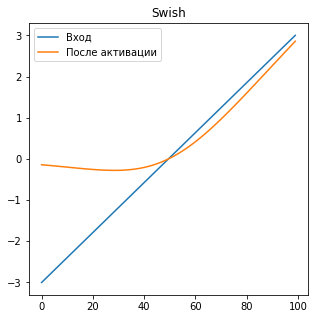

In [28]:
import matplotlib.pyplot as plt
from torch import nn
swish = nn.SiLU()

array = torch.linspace(-3,3,100)
activated = swish(array)

fig = plt.figure(figsize=(5,5))
plt.plot(array, label='Вход')
plt.plot(activated, label='После активации')
plt.legend()
plt.title('Swish')


### Depthwise separable convolution

В то время как стандартная свертка выполняет поканальные и пространственно-временные вычисления за один шаг, разделимая по глубине свертка (*Depthwise separable convolution*) разделяет вычисления на два этапа: глубинная свертка применяет один сверточный фильтр для каждого входного канала, а точечная свертка используется для создания линейной комбинации выходных данных глубинной свертки. 

<img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img/L09_CNN_Architectures_41.png"  width="850">

<img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img/L09_CNN_Architectures_42.png"  width="850">

In [ ]:
from torchvision import models,utils
mobilenet = models.mobilenet_v3_small(pretrained=True)
print(mobilenet)

##### $\color{brown}{\text{Допольнительная информация}}$ 

###### Shuffled Grouped Convolution

<img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img/L09_CNN_Architectures_43.png"  width="850">

###### Neural Architecture Search

<img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img/L09_CNN_Architectures_44.png"  width="850">

## 2019 EfficientNet

Фишка EfficientNet в равномерном масштабировании всех измерений (глубины/ширины/разрешения) с помощью составного коэффициента (*compound coefficient*). 

Например, если мы хотим использовать в $2^N$ больше вычислительных ресурсов, то мы можем просто увеличить глубину сети на $\alpha^N$ ширину на $\beta^N$ и размер изображения на $\gamma^N$ где - $\alpha$, $\beta$ и $\gamma$ постоянные коэффициенты, определяемые grid search на исходной немасштабированной модели.



Метод комбинированного масштабирования обоснован следующей интуицией - если мы берем более большое входное изображение чем обычно (например 1024x1024 вместо привычных 256x256), то сети потребуется больше слоев для увеличения рецептивного поля и больше каналов для захвата более тонких деталей на большом изображении.

Базовая сеть EfficientNet основана на инвертированных узких остаточных блоках MobileNet, в дополнение к блокам сжатия и возбуждения (*squeeze-and-excitation blocks*).

**МЕСТО ДЛЯ [ВОТ ЭТОЙ КАРТИНКИ](https://paperswithcode.com/media/methods/Screen_Shot_2020-06-06_at_10.45.54_PM.png) ОТРИСОВАННОЙ КОНТЕНТОМ**

In [ ]:
!pip install efficientnet_pytorch

In [ ]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b0')
print(model)

## 2020 Visual Transformers

<img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img/L09_CNN_Architectures_45.png"  width="850">

[2020 Visual Transformers: Token-based Image Representation and Processing for Computer Vision](https://arxiv.org/abs/2006.03677)

Vision Transformer - это модель для классификации изображений, которая использует архитектуру трансформера.

Visual Transformer обращает внимание только на важные области (которые определяет с помощью механизма attention), кодирует семантические понятия в несколько визуальных токенов, связывая пространственно удаленные понятия с помощью self-attention. Эти визуальные токены могут быть использованы для классификации изображений или спроецированы обратно на карту признаков для семантической сегментации.

<img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img/L09_CNN_Architectures_46.png"  width="850">

[Реализация](https://github.com/lucidrains/vit-pytorch)

[Блог-пост разбор  ViT](https://towardsdatascience.com/implementing-visualttransformer-in-pytorch-184f9f16f632)

#### Load data

In [ ]:
import torchvision
from torchvision.datasets import CIFAR10

transform = torchvision.transforms.Compose([
                                            torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],[0.2470, 0.2434, 0.2615])
                                            ]) 

trainset = CIFAR10(root='./CIFAR10', train=True, download=True, transform=transform)
testset = CIFAR10(root='./CIFAR10', train=False, download=True, transform=transform)

trainset_mini, _ = torch.utils.data.random_split(trainset, [20000, 30000])
testset_mini, _ = torch.utils.data.random_split(testset, [2000, 8000])

from torch.utils.data import DataLoader
batch_size = 256

trainloader = DataLoader(trainset_mini, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset_mini, batch_size=batch_size, shuffle=False, num_workers=2)

#### Split image into pathches

В примере ниже это происходит внутри модели. Данный код приведен в качестве иллюстрации.

In [ ]:
from torchvision import models,utils
import matplotlib.pyplot as plt
import numpy as np
import torch

im = testset[0][0]
patches = []
sz = 8
for r in range(0,im.shape[1] , sz):
    for c in range(0,im.shape[2] , sz):
        patches.append(im[:,r:r+sz,c:c+sz])

patches = torch.stack(patches).type(torch.float)

img_grid = utils.make_grid(patches,pad_value=10,normalize=True,nrow=4)
plt.imshow(np.transpose(img_grid , (1, 2, 0)))


#### Install Visual transformer

In [ ]:
!pip install vit-pytorch

In [ ]:
# Validation function. Don't change this code

import torch.optim as optim

def validate(model,testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total  

In [ ]:
reinit_tensorboard()

In [ ]:
import torch
from torch import nn
from vit_pytorch import ViT
from torch.utils.tensorboard import SummaryWriter

model  = ViT(
    image_size = 32,
    patch_size = 4,
    num_classes = 10,
    dim = 256,
    depth = 6,
    heads = 16,
    mlp_dim = 1024,
    dropout = 0.1,
    emb_dropout = 0.1
)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)


def train(model,loss_function,optimizer , epochs = 50, tag = "cifar10"):
  
  writer = SummaryWriter(comment = tag)

  for epoch in range(epochs):
    hist_loss = 0
    correct = 0
    model.to(device)
    for images, labels in trainloader: # get bacth         
        optimizer.zero_grad() # sets the gradients of all optimized tensors to zero.
        outputs = model(images.to(device)) # call forward inside 
        loss = loss_function(outputs, labels.to(device)) # calculate loss
        loss.backward() # calculate gradients
        optimizer.step() # performs a single optimization step (parameter update).
        # stat collection
        _, predicted = torch.max(outputs.data, 1)  
        correct += (predicted == labels.to(device)).sum().item()
        hist_loss += loss.item()
   
    accuracy_v  = validate(model.cpu(), testloader)
    print(accuracy_v)
   
    writer.add_scalars("Accuracy", { 
          'Val': accuracy_v,
          'Train' : correct / len(trainloader.dataset)
      }, epoch)

    writer.add_scalars("Loss", { 
          
          'Train': hist_loss /  len(trainloader),
      }, epoch)
    writer.close()

  return accuracy_v


optimizer = torch.optim.Adam(model.parameters(), lr=0.01) 
train(model, nn.CrossEntropyLoss(), optimizer, epochs =10, tag = 'ViT' )

## Практические аспекты работы с размерностью данных

In [30]:
def conv_chain(input_size, output_size, depth, cond):
    '''Written by Francois Fleuret <francois@fleuret.org>'''
    if depth == 0:
        if input_size == output_size:
            return [ [ ] ]
        else:
            return [ ]
    else:
        r = [ ]
        for kernel_size in range(1, input_size + 1):
            for stride in range(1, input_size):
                if cond(depth, kernel_size, stride):
                    n = (input_size - kernel_size) // stride + 1
                    if n >= output_size and (n - 1) * stride + kernel_size == input_size:
                        q = conv_chain(n, output_size, depth - 1, cond)
                        r += [ [ (kernel_size, stride) ] + u for u in q ]
        return r

Частая проблема при написании архитектур это посчитать промежуточные размеры сверток. К счастью эта проблема решается довольно простой функцией. 

На вход подаем наш размер (например картинки), и размер который мы хотим получить на выходе. Указываем количество слоев и дополнительные параметры (например нам нужны kernels меньше 4, страйды меньше, чем ядра, и страйды, равные 1, за исключением двух последних слоев)

In [37]:
import torch
from torch import nn

c = conv_chain(
    input_size = 64, output_size = 8,
    depth = 5,
    # We want kernels smaller than 4, strides smaller than the
    # kernels, and strides of 1 except in the two last layers
    cond = lambda d, k, s: k <= 4 and s <= k and (s == 1 or d <= 2)
)

x = torch.rand(1, 1, 64, 64)

# Функция нам выдаст все возможные варианты моделей
for num, m in enumerate(c):
    model = nn.Sequential(*[ nn.Conv2d(1, 1, l[0], l[1]) for l in m ])
    
    print("Вариант {}".format(num))
    print(model)
    print(x.size(), model(x).size())
    print(' ')

Вариант 0
Sequential(
  (0): Conv2d(1, 1, kernel_size=(1, 1), stride=(1, 1))
  (1): Conv2d(1, 1, kernel_size=(1, 1), stride=(1, 1))
  (2): Conv2d(1, 1, kernel_size=(1, 1), stride=(1, 1))
  (3): Conv2d(1, 1, kernel_size=(2, 2), stride=(2, 2))
  (4): Conv2d(1, 1, kernel_size=(4, 4), stride=(4, 4))
)
torch.Size([1, 1, 64, 64]) torch.Size([1, 1, 8, 8])
 
Вариант 1
Sequential(
  (0): Conv2d(1, 1, kernel_size=(1, 1), stride=(1, 1))
  (1): Conv2d(1, 1, kernel_size=(1, 1), stride=(1, 1))
  (2): Conv2d(1, 1, kernel_size=(1, 1), stride=(1, 1))
  (3): Conv2d(1, 1, kernel_size=(4, 4), stride=(4, 4))
  (4): Conv2d(1, 1, kernel_size=(2, 2), stride=(2, 2))
)
torch.Size([1, 1, 64, 64]) torch.Size([1, 1, 8, 8])
 
Вариант 2
Sequential(
  (0): Conv2d(1, 1, kernel_size=(4, 4), stride=(1, 1))
  (1): Conv2d(1, 1, kernel_size=(4, 4), stride=(1, 1))
  (2): Conv2d(1, 1, kernel_size=(4, 4), stride=(1, 1))
  (3): Conv2d(1, 1, kernel_size=(4, 4), stride=(3, 3))
  (4): Conv2d(1, 1, kernel_size=(4, 4), stride=(2, 2

# Список использованной литературы

[Подробнее про AlexNet](https://neurohive.io/ru/vidy-nejrosetej/alexnet-svjortochnaja-nejronnaja-set-dlja-raspoznavanija-izobrazhenij/)

[ImageNet Classification with Deep ConvolutionalNeural Networks](https://papers.nips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf)

[Краткое описание VGGNet](https://www.robots.ox.ac.uk/~vgg/research/very_deep/)

[2014 Network In Network](https://arxiv.org/pdf/1312.4400.pdf)

[Global Average Pooling](https://alexisbcook.github.io/2017/global-average-pooling-layers-for-object-localization/)

[Going deeper with convolutions](https://arxiv.org/abs/1409.4842)

[2015 Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf)

[Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf)

[Benchmark Analysis of Representative Deep Neural Network Architectures](https://arxiv.org/pdf/1810.00736.pdf)

[2016 Aggregated Residual Transformations for Deep Neural Networks](https://arxiv.org/abs/1611.05431)


[Блог-пост про различные типы сверток](https://towardsdatascience.com/a-comprehensive-introduction-to-different-types-of-convolutions-in-deep-learning-669281e58215)

[2016 Wide Residual Networks](https://arxiv.org/abs/1605.07146)

[2017 Squeeze-and-Excitation Networks](https://arxiv.org/abs/1709.01507)

[2020 Visual Transformers: Token-based Image Representation and Processing for Computer Vision](https://arxiv.org/abs/2006.03677)